In [2]:
import numpy as np
import pydicom
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
import nibabel as nib
from scipy.stats.distributions import norm
from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde
import scipy.integrate as integrate
from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.nonparametric.kernel_density import KDEMultivariate
import gc
gc.enable
warnings.filterwarnings("ignore")

In [3]:
# Data loading
t1_img = nib.load('mni_icbm152_t1_tal_nlin_asym_09a.nii')
t1_data = t1_img.get_data()
t2_img = nib.load('mni_icbm152_t2_tal_nlin_asym_09a.nii')
t2_data = t2_img.get_data()
# Slice of the Nifti image
t1_slice = t1_data[:, :, 94]
t2_slice = t2_data[:, :, 94]

In [4]:
# Flat the vector
t1 = t1_slice.flatten()
t2 = t2_slice.flatten()

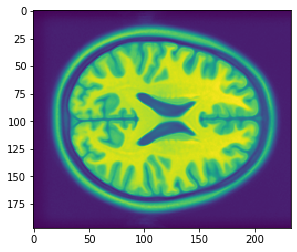

In [5]:
plt.imshow(t1_slice)

In [23]:
def kde_scipy(x, x_grid, bandwidth=0.2, **kwargs):
    """Kernel Density Estimation with Scipy"""
    # Note that scipy weights its bandwidth by the covariance of the
    # input data.  To make the results comparable to the other methods,
    # we divide the bandwidth by the sample standard deviation here.
    kde = gaussian_kde(x, bw_method=bandwidth / x.std(ddof=1), **kwargs)
    return kde.evaluate(x_grid)


def kde_statsmodels_u(x, x_grid, bandwidth=0.2, **kwargs):
    """Univariate Kernel Density Estimation with Statsmodels"""
    kde = KDEUnivariate(x)
    kde.fit(bw=bandwidth, **kwargs)
    return kde.evaluate(x_grid)
    
    
def kde_statsmodels_m(x, x_grid, bandwidth=0.2, **kwargs):
    """Multivariate Kernel Density Estimation with Statsmodels"""
    kde = KDEMultivariate(x, var_type = 'c', bw = [0.2])
    return kde.pdf(x_grid)


def kde_sklearn(x, x_grid, bandwidth=0.2, **kwargs):
    """Kernel Density Estimation with Scikit-learn"""
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
    return np.exp(log_pdf)


kde_funcs = [kde_statsmodels_u, kde_statsmodels_m, kde_scipy, kde_sklearn]
kde_funcnames = ['Statsmodels-U', 'Statsmodels-M', 'Scipy', 'Scikit-learn']

In [21]:
np.max(t1)

90.55689174856525

In [7]:
t1.shape

(45901,)

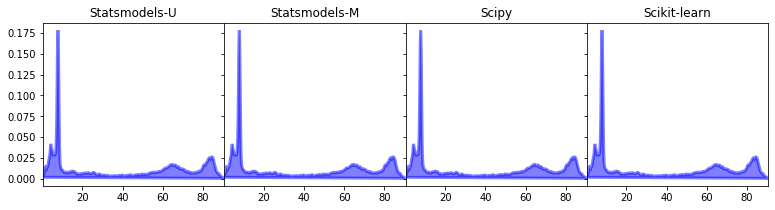

In [26]:
# The grid we'll use for plotting
x_grid = np.linspace(0.3, 90.5, 1000)

# Draw points from a bimodal distribution in 1D
np.random.seed(0)
x = np.concatenate([norm(-1, 1.).rvs(400),
                    norm(1, 0.3).rvs(100)])
pdf_true = (0.8 * norm(-1, 1).pdf(x_grid) +
            0.2 * norm(1, 0.3).pdf(x_grid))

# Plot the three kernel density estimates
fig, ax = plt.subplots(1, 4, sharey=True,
                       figsize=(13, 3))
fig.subplots_adjust(wspace=0)

x = t1

for i in range(4):
   
    pdf = kde_funcs[i](x, x_grid, bandwidth=0.2)
    ax[i].fill(x_grid, pdf, color='blue', alpha=0.5, lw=3)
    #ax[i].fill(x_grid, pdf_true, ec='gray', fc='gray', alpha=0.4)
    ax[i].set_title(kde_funcnames[i])
    ax[i].set_xlim(0.3,90.5)


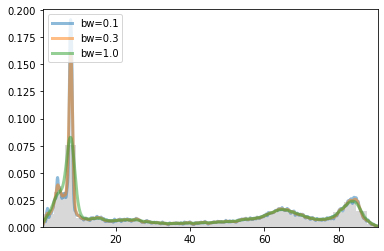

In [28]:
fig, ax = plt.subplots()
for bandwidth in [0.1, 0.3, 1.0]:
    ax.plot(x_grid, kde_sklearn(x, x_grid, bandwidth=bandwidth),
            label='bw={0}'.format(bandwidth), linewidth=3, alpha=0.5)
ax.hist(x, 30, fc='gray', histtype='stepfilled', alpha=0.3, density=True)
ax.set_xlim(0.3,90.5)
ax.legend(loc='upper left')
plt.show()

In [30]:
dens_u = KDEMultivariate(data=[t1,t2],
                         var_type='cc', bw='normal_reference')

In [8]:
kde = KernelDensity(kernel='epanechnikov', algorithm='ball_tree',bandwidth=0.2).fit(np.array([t1,t2]).transpose())

In [9]:
kde

KernelDensity(algorithm='ball_tree', atol=0, bandwidth=0.2, breadth_first=True,
              kernel='epanechnikov', leaf_size=40, metric='euclidean',
              metric_params=None, rtol=0)

In [14]:
im_1 = pydicom.dcmread('im_1.dcm').pixel_array.flatten()
im_2 = pydicom.dcmread('im_2.dcm').pixel_array.flatten()

In [3]:
im_1.shape

(262144,)

In [18]:
XY = np.vstack((t1,t2)).T
n = XY.shape[0]

In [32]:
XY[:,0]

array([0.30434677, 0.47134305, 0.37293453, ..., 1.34210939, 1.40920611,
       1.09161496])